In [ ]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount = True)

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/ML Project/FireNet-LightWeight-Network-for-Fire-Detection

/content/gdrive/MyDrive/ML Project/FireNet-LightWeight-Network-for-Fire-Detection


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import zipfile
from PIL import Image
import tempfile
import matplotlib.pyplot as plt
import random
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model


In [ ]:
DATADIR = 'Dataset/Training_Dataset.zip'
CATEGORIES = ['Fire', 'NoFire']

In [ ]:
IMG_SIZE = 64
def create_training_data():
    training_data = []
    zfile = zipfile.ZipFile(DATADIR, 'r')
    for category in CATEGORIES:
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=C 1=O
        filename = 'fire' if class_num == 0 else "nofire"

        for i in tqdm(range(1500)):  # iterate over each image
            try:
                data = zfile.read(f'Training Dataset/{category}/{filename}{i}.jpg')
                img_array = cv2.imdecode(np.frombuffer(data, np.uint8), 1)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
    
    zfile.close()
              
    return training_data

In [ ]:
training_data = create_training_data()


100%|██████████| 1500/1500 [00:27<00:00, 54.30it/s]


In [ ]:
print(len(training_data))
random.shuffle(training_data)

2422
1
0
1
1
0
0
1
1
1
1


In [ ]:
X = []
Y = []

for features,label in training_data:
    X.append(features)
    Y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X = X/255.0
X.shape[1:]

(64, 64, 3)

In [ ]:
image = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15, width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,horizontal_flip=True)
image.fit(X)

<h2> Main Model </h2>

In [ ]:
input = layers.Input(shape = (64,64,3))

CNN_1 = layers.Conv2D(filters = 32,kernel_size = (3,3),kernel_initializer = 'he_normal',activation = 'elu',padding = 'same')(input)
BN_1 = layers.BatchNormalization()(CNN_1)
Pool_1 = layers.AveragePooling2D()(BN_1)
Drop_1 = layers.Dropout(0.65)(Pool_1)

CNN_2 = layers.Conv2D(filters = 128,kernel_size = (3,3),kernel_initializer = 'he_normal',activation = 'elu',padding = 'same')(Drop_1)
BN_2 = layers.BatchNormalization()(CNN_2)
Pool_2 = layers.AveragePooling2D()(BN_2)
Drop_2 = layers.Dropout(0.7)(Pool_2)

CNN_3 = layers.Conv2D(filters = 128,kernel_size = (3,3),kernel_initializer = 'he_normal',activation = 'elu',padding = 'same')(Drop_2)
BN_3 = layers.BatchNormalization()(CNN_3)
Pool_3 = layers.AveragePooling2D()(BN_3)
Drop_3 = layers.Dropout(0.85)(Pool_3)

CNN_4 = layers.Conv2D(filters = 256,kernel_size = (3,3),kernel_initializer = 'he_normal',activation = 'elu',padding = 'same')(Drop_3)
BN_4 = layers.BatchNormalization()(CNN_4)
Pool_3 = layers.AveragePooling2D()(BN_4)
Drop_4 = layers.Dropout(0.9)(Pool_3)

flat = layers.Flatten()(Drop_4)
dense_1 = layers.Dense(128,activation = 'elu',kernel_initializer = 'he_normal')(flat)
dense_2 = layers.Dense(64,activation = 'elu',kernel_initializer = 'he_normal')(dense_1)
dense_3 = layers.Dense(2,activation = 'softmax')(dense_2)

model = keras.Model(input,dense_3,name = 'model_final')

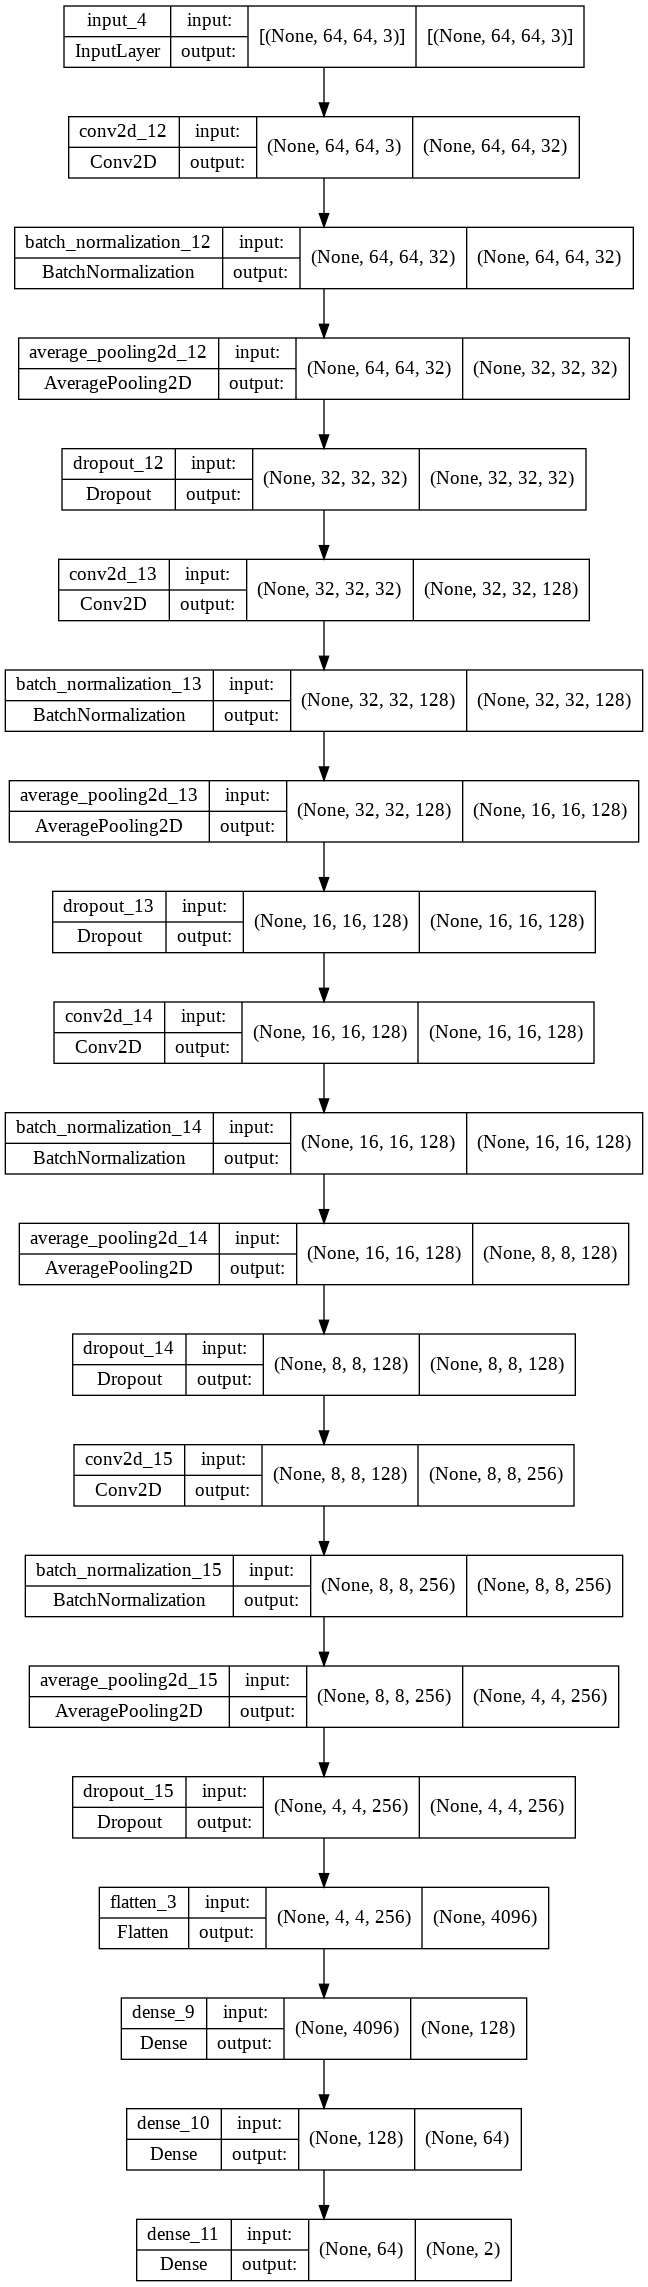

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
checkpoint_filepath = 'TrainedModels/Models/weights.{epoch:02d}-{val_accuracy:.4f}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X, np.array(Y), batch_size=32, epochs=300,validation_split=0.3,callbacks = model_checkpoint_callback)

Epoch 1/300
53/53 [==============================] - 3s 39ms/step - loss: 1.0725 - accuracy: 0.6519 - val_loss: 0.5777 - val_accuracy: 0.7469
Epoch 2/300
53/53 [==============================] - 1s 27ms/step - loss: 0.7504 - accuracy: 0.6643 - val_loss: 0.6983 - val_accuracy: 0.5365
Epoch 3/300
53/53 [==============================] - 2s 30ms/step - loss: 0.6495 - accuracy: 0.6861 - val_loss: 0.8286 - val_accuracy: 0.5144
Epoch 4/300
53/53 [==============================] - 1s 27ms/step - loss: 0.6585 - accuracy: 0.7044 - val_loss: 0.9040 - val_accuracy: 0.5447
Epoch 5/300
53/53 [==============================] - 1s 27ms/step - loss: 0.6090 - accuracy: 0.7333 - val_loss: 1.0656 - val_accuracy: 0.5351
Epoch 6/300
53/53 [==============================] - 1s 27ms/step - loss: 0.5563 - accuracy: 0.7528 - val_loss: 0.9328 - val_accuracy: 0.5571
Epoch 7/300
53/53 [==============================] - 2s 30ms/step - loss: 0.5710 - accuracy: 0.7404 - val_loss: 0.9998 - val_accuracy: 0.4911
Epoch 

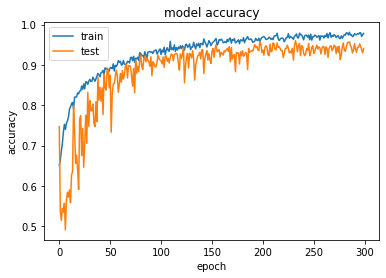

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

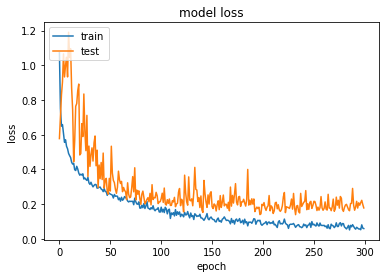

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss.png')
plt.show()
